### > install packages

In [1]:
!pip install -Uq opencv-python-headless
!pip install -Uq diffusers==0.21.4

### > setup

In [2]:
# !pip install opencv-python transformers accelerate
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch
import gc

import cv2
from PIL import Image

device_count = torch.cuda.device_count()
assert device_count > 0, "No GPU devices detected."

print("Number of available GPU devices:", device_count)

device = torch.device("cuda:0")

2024-06-23 22:52:35.072060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of available GPU devices: 1


### > download reference image

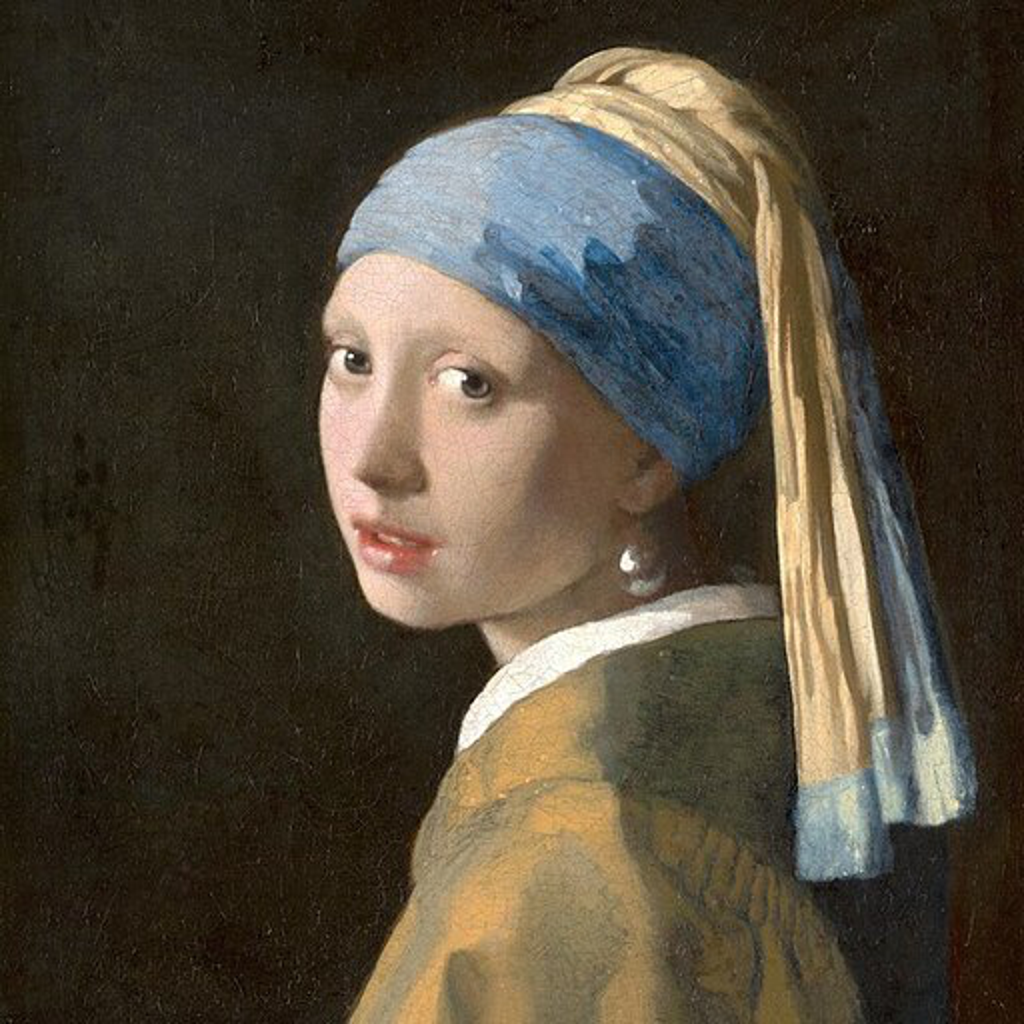

In [3]:
# download an image
# image = load_image(
#     "https://hf.co/datasets/hf-internal-testing/diffusers-images/resolve/main/sd_controlnet/hf-logo.png"
# )
# image
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
).resize((1024, 1024))
image

### > import your own image

In [7]:
def scale_image_proportionally(image_path, long_side_length):
    """
    Scales an image proportionally based on the longer side.

    :param image_path: Path to the input image.
    :param output_path: Path to save the scaled image.
    :param long_side_length: Desired length of the longer side of the scaled image.
    """
    with Image.open(image_path) as img:
        # Get original dimensions
        original_width, original_height = img.size

        # Determine the scaling factor
        if original_width > original_height:
            scale_factor = long_side_length / original_width
        else:
            scale_factor = long_side_length / original_height

        # Calculate new dimensions
        new_width = int(original_width * scale_factor)
        new_height = int(original_height * scale_factor)

        # Resize the image
        scaled_img = img.resize((new_width, new_height), Image.LANCZOS)

        return scaled_img

In [8]:
def center_crop_and_resize(image_path, new_size):
    # Open the image
    image = Image.open(image_path)

    # Calculate the coordinates for center cropping
    width, height = image.size
    left = (width - min(width, height)) // 2
    top = (height - min(width, height)) // 2
    right = (width + min(width, height)) // 2
    bottom = (height + min(width, height)) // 2

    # Perform center cropping
    image = image.crop((left, top, right, bottom))

    # Resize the image to the new size
    image = image.resize(new_size)

    return image

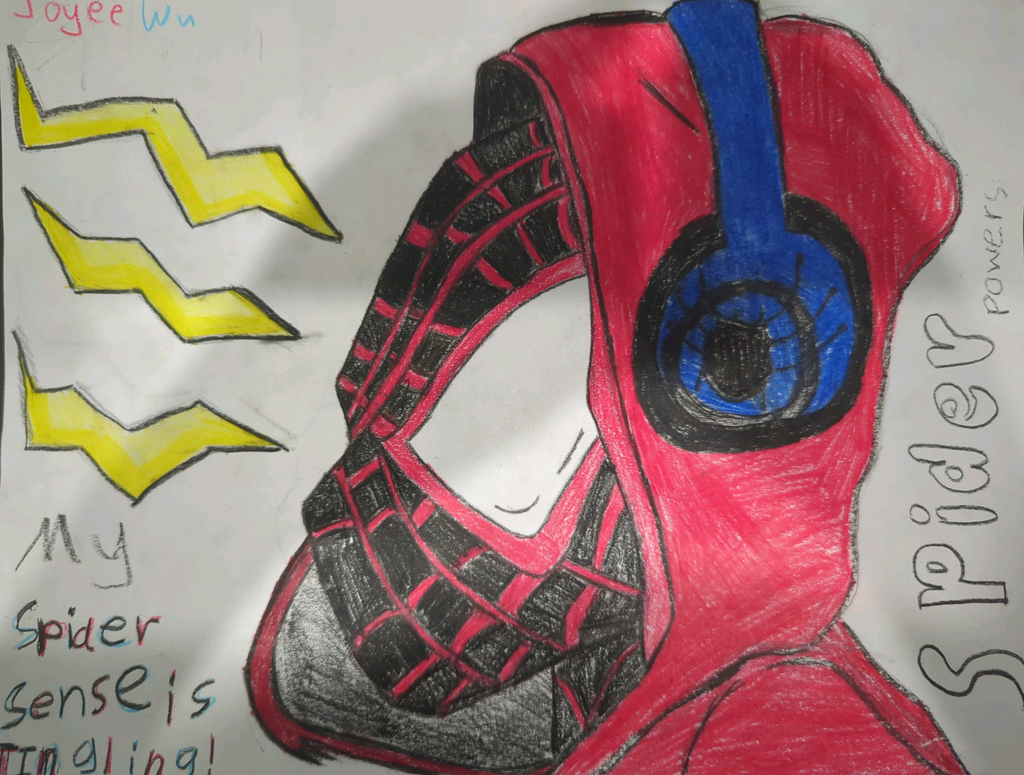

In [9]:
image_path = "spidey.jpg"

result_image = scale_image_proportionally(image_path, 1024)
result_image

### > load the model

In [10]:
# initialize the models and pipeline
controlnet_conditioning_scale = 0.5  # recommended for good generalization
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, vae=vae, torch_dtype=torch.float16
).to(device)

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

(…)_1_0/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [16]:
# pipe.enable_xformers_memory_efficient_attention()

In [32]:
prompt = "miles morales spiderman wearing a red hoodie with blue headphones"
negative_prompt = "low quality, bad quality, sketches"

### > generate image

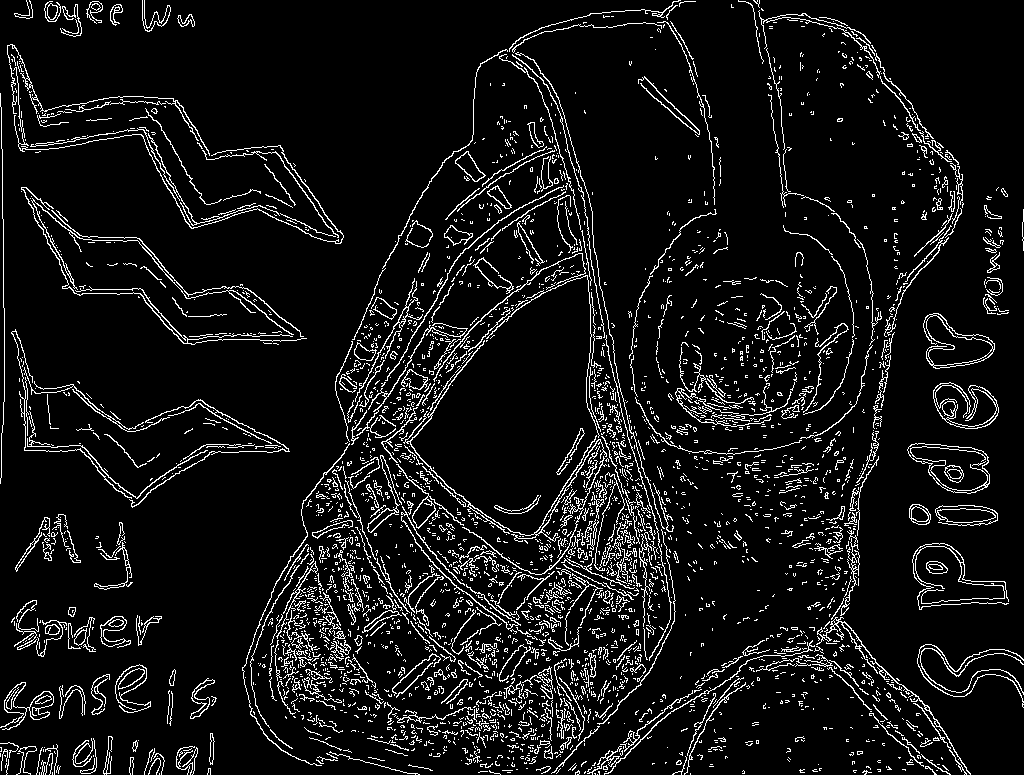

In [33]:
# get canny image
image = np.array(result_image)
image = cv2.Canny(image, 150, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

  0%|          | 0/50 [00:00<?, ?it/s]

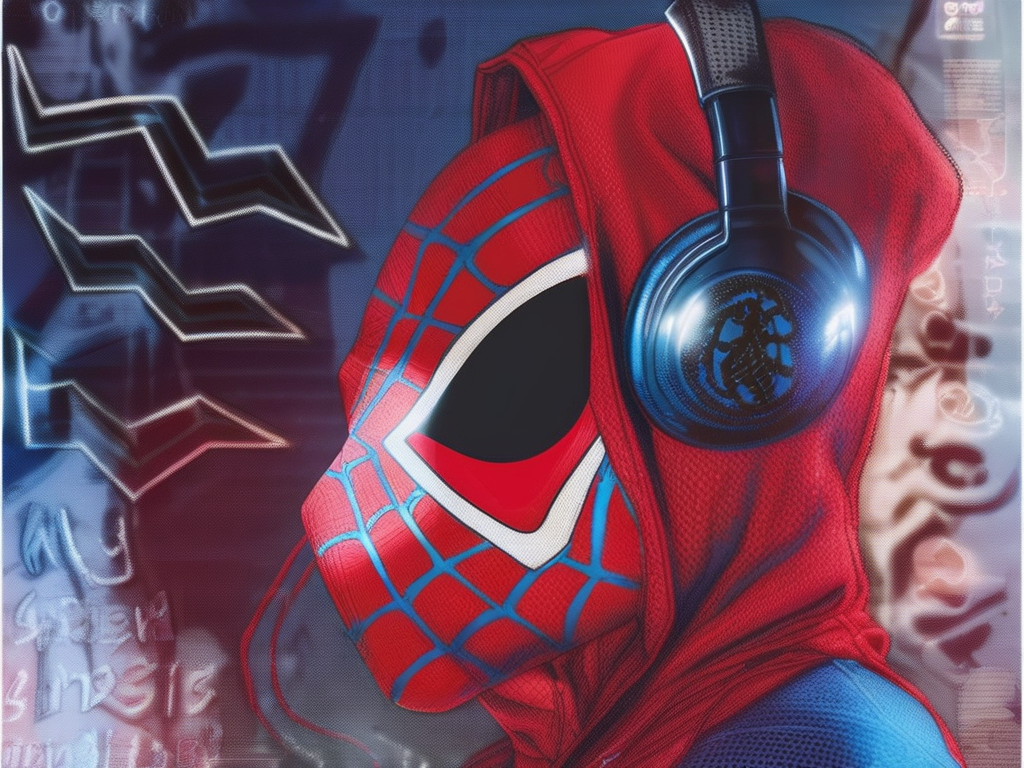

In [36]:
import random

generator = torch.manual_seed(random.randint(0, 1000000000))

# generate image
image = pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=controlnet_conditioning_scale, 
    # generator=generator,
    image=canny_image
).images[0]
image

In [37]:
del pipe
gc.collect()
torch.cuda.empty_cache()